# Dive Into Seattle Airbnb Data
---

## Getting Started
Based on the CRISP-DM (Cross Industry Process for Data Mining), we will try to analyze the Airbnb Seattle's datasets.

## 1. Business Understanding 
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, the dataset describes the listing activity of homestays in Seattle, WA. [(source)](http://insideairbnb.com/seattle/)

Some of key questions, for which we will be investigating answers are:
>**Q1. Does the price spikes in the busiest time of the year?**<br>
**Q2. Is there any trend in Airbnb listings and total vistors? And,**<br>
**Q3. How well can we predict a price of Seattle Airbnb listings?**

## 2. Data Understanding
AirBnB has provide us three [dataset](http://insideairbnb.com/get-the-data.html) from Seattle:
- **listings.csv** - contains the detailed information about the places, locations, host details, amenities, charges, etc.
- **calender.csv** - has the information regarding all the bookings made so far.
- **reviews.csv** - contains summary review of listings.

In [1]:
# import essential packages 
import numpy as np
import pandas as pd
import re

import seaborn as sns
base_color = sns.color_palette()[0]

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

###  2.1. Insights from listings.csv dataset.

Last scraped date: 2020-05-21
Total columns with null values: 40


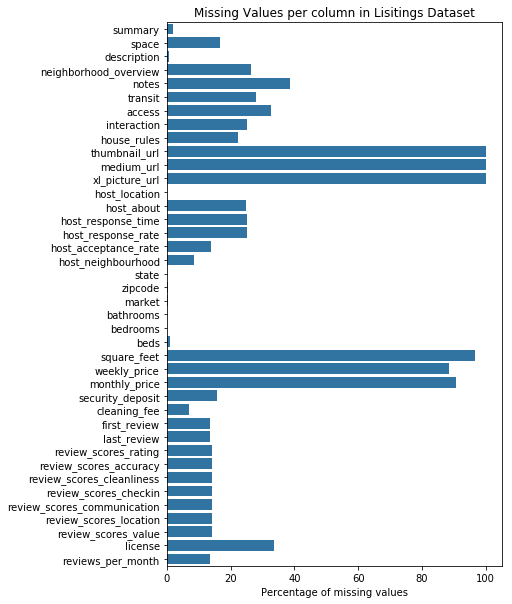

In [2]:
# loading the listing data
listings_df = pd.read_csv("listings.csv")

# Last scraped date
print("Last scraped date:", listings_df.last_scraped.min())

# counting the columns with listings missing value
print("Total columns with null values: {}".format(np.sum(listings_df.isnull().mean() != 0)))

# amount of listings_missing values
listings_missing = listings_df.isna().mean()*100

# Columns with NaN values
listings_missing_nan = listings_missing[listings_missing > 0]

# ploting the listings_missing values
plt.figure(figsize=[6, 10])
plt.title("Missing Values per column in Lisitings Dataset")
plt.xlabel("Percentage of missing values")
sns.barplot(listings_missing_nan, listings_missing_nan.index.values, color=base_color)
plt.show();

_**Listings Data Summary:**_

- The information is updated to as of 21<sup>st</sup> May, 2020.
- Most of the URL columns are NaN values, we will drop them later.
- 'scrape_id' and 'last_scraped' columns have all same data.
- All the columns containing date needs to be formatted.
- 'host_response_rate' and 'host_acceptance_rate' have '%' mark. They will have to be changed to numeric.
- Some columns contains list in it, such as 'host verification', 'amenities' and 'jurisdiction_names'.
- There are some currency columns from which '$' and ',' marks needs to remove.
- We will use 'price' column as a target of prediction model.

###  2.2. Insights from calendar.csv dataset.

In [3]:
# loading the calendar dataset
calendar_df = pd.read_csv('calendar.csv')

# get the dates range in dataset
print("Date ranges from {} till {}.".format(calendar_df.date.min(), calendar_df.date.max()))

# change date range to number of days
print("Date available for {} days.".format(calendar_df.groupby('listing_id').count()['date'].unique()))

# counting the missing value in dataframe
print("Total columns having null values: ", (calendar_df.isnull().mean() != 0).sum())

Date ranges from 2020-05-21 till 2021-05-24.
Date available for [365] days.
Total columns having null values:  0


_**Calendar Data Summary:**_

- Price in calendar dataset is available for 365 days, can be use for getting monthly mean values. 
- 'date' column is in string type and we need to format it. 

###  2.3. Insights from reviews.csv dataset.

In [4]:
# loading the reviews dataset
reviews_df = pd.read_csv('reviews.csv')

# first reviewed date
print("First review noted on :", reviews_df.date.max())

# last reviewed date
print("Last review noted on :", reviews_df.date.min())

# counting the missing value in dataframe
print("Total columns having null values: ", (reviews_df.isnull().mean() != 0).sum())

First review noted on : 2020-05-20
Last review noted on : 2008-09-15
Total columns having null values:  1


_**Reviews Data Summary:**_

- This data is collecting reviews over thirteen years period. We can get review count trend in timeline as well as reviewed listing count trend.
- 'date' column is in string type and we might need format conversion later.
- Only 'comments' column has a few NaN.

## 3. Preparing the Data

### 3.1. Prepare the Listings dataset.

>**TODO:**
- Seperate the columns of dataset into different category lists.
- Dropping the URL columns, as most values in them are NaN.
- Convert the free text columns into size information.
- Casting the columns containing date to pandas datetime format.
- Analyse the reviews columns for NaN distribution.
- Check location columns for redundancies and duplicates.
- Convert % columns into numeric.
- Remove '$' and ',' from price columns and convert them into numeric.
- Check distribution of numeric columns overall for NaN and outliers.
- Decode special columns: 'host_verifications', 'amenities', and 'calendar_updated'.
- Dummy encode all categorical columns.
- Drop all from dropping columns.
- Drop all id columns except 'id'. Make 'id' colum into index.

#### 3.1.1. Seperate the columns of dataset into different category lists.

In [5]:
id_cols = ['id', 'scrape_id', 'host_id']

url_cols = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 
            'xl_picture_url', 'host_url','host_thumbnail_url', 'host_picture_url']

text_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 
             'transit', 'host_name', 'access', 'interaction', 'house_rules', 'host_about']

date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

review_cols = ['number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 
               'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value', 
               'reviews_per_month']

location_cols = ['host_location', 'host_neighbourhood', 'street', 'neighbourhood', 'neighbourhood_cleansed',
                 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location',
                 'country_code', 'country', 'jurisdiction_names']

percent_cols = ['host_response_rate', 'host_acceptance_rate']

price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

num_cols = ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 
            'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
            'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365']

encoded_cols = ['host_verifications', 'amenities', 'calendar_updated']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
            'is_location_exact', 'property_type', 'room_type', 'bed_type', 'has_availability',
            'requires_license', 'instant_bookable', 'cancellation_policy',
            'require_guest_profile_picture', 'require_guest_phone_verification']

# list of all the miscellaneous column to drop, for avoiding overfitting later.
dropping_cols = ['experiences_offered', 'square_feet', 'license', 
                 'is_business_travel_ready', 'number_of_reviews_ltm',
                 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',]

In [6]:
# check that all columns are in different category lists
all_cols = [dropping_cols, id_cols, url_cols, text_cols, date_cols, review_cols,
            location_cols, cat_cols, num_cols, percent_cols, encoded_cols, price_cols]

set(np.concatenate(all_cols)) == set(listings_df.columns.values)

True

#### 3.1.2. Dropping the URL columns, as most values in them are NaN.

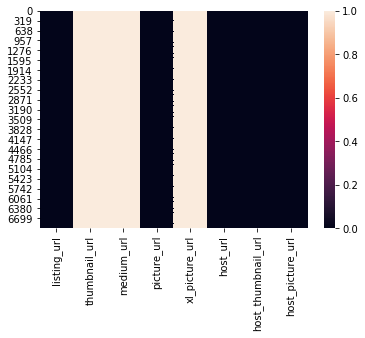

In [7]:
# checking URL columns NaN distribution
sns.heatmap(listings_df[url_cols].isnull())
plt.show()

Three of URL columns have same NaN distribution. So one binary column for three of them will be created for extra URL availability.<br>
Others are all or almost filled and no differentiation is possible. Thus, they are moved to 'dropping_cols' list.

In [8]:
# 'thumbnail_url' column is used as a representative of three extra URL columns.
listings_df['has_extra_urls'] = listings_df['thumbnail_url'].notnull().astype(int)

In [9]:
# adding url columns to 'dropping_cols'
dropping_cols += url_cols

#### 3.1.3 Convert the free text columns into size information.

In [10]:
# Convert text columns into lenght of them. NaN will be replaced with zero.
for col in text_cols:
    listings_df[col] = listings_df[col].apply(lambda x: len(x) if type(x) == str else 0)

In [11]:
# understanding the text distribution
listings_df[text_cols].describe()

,name,summary,space,description,neighborhood_overview,notes,transit,host_name,access,interaction,house_rules,host_about
count,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000,7017.000000
mean,39.291008,361.722531,471.130825,899.187545,306.088784,230.323358,238.064843,7.039761,146.653128,150.506057,349.477555,342.680775
std,11.332324,141.078380,366.963630,232.997475,303.122990,293.164221,261.307832,4.434207,188.491052,162.614459,381.704067,384.226643
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,248.000000,143.000000,1000.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,23.000000,2.000000
50%,41.000000,383.000000,410.000000,1000.000000,237.000000,109.000000,166.000000,6.000000,90.000000,116.000000,172.000000,242.000000
75%,48.000000,486.000000,851.000000,1000.000000,467.000000,367.000000,346.000000,7.000000,209.000000,212.000000,623.000000,526.000000
max,136.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,34.000000,1000.000000,1000.000000,1000.000000,4198.000000


- Still 'name' and 'host_name' are irrelevant as prediction features. They will be moved to 'dropping_cols' list.

In [12]:
# move unwanted into dropping list.
dropping_cols += ['name', 'host_name']

#### 3.1.4. Casting the columns containing date to pandas datetime format.

In [13]:
# convert date columns into pandas datetime format.
for col in date_cols:
    listings_df[col] = pd.to_datetime(listings_df[col])

# understanding the dates distribution
listings_df[date_cols].describe()

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
count,7017,7017,7017,6076,6076
unique,2,2236,2,2007,952
top,2020-05-21 00:00:00,2013-08-30 00:00:00,2020-05-21 00:00:00,2019-07-07 00:00:00,2020-03-01 00:00:00
freq,7010,244,7010,18,142
first,2020-05-21 00:00:00,2008-08-26 00:00:00,2020-05-21 00:00:00,2008-09-15 00:00:00,2012-06-06 00:00:00
last,2020-05-25 00:00:00,2020-05-16 00:00:00,2020-05-25 00:00:00,2020-05-18 00:00:00,2020-05-20 00:00:00


- 'last_scraped' and 'calendar_last_scraped' columns are constant. So they will be moved to 'dropping_cols' list.
- Making 'last_scaped' date as end point, converting the rest of three dates into period till the 'last_scraped' date.

In [14]:
# moving the unwanted columns to 'dropping_cols' list
dropping_cols += ['last_scraped', 'calendar_last_scraped']
date_cols.remove('last_scraped')
date_cols.remove('calendar_last_scraped')

# converting date_cols into duration till 'last_scraped' date.
for col in date_cols:
    listings_df[col] = listings_df['last_scraped'] - listings_df[col]
    listings_df[col] = listings_df[col].dt.components.days

#### 3.1.5. Analyse the reviews columns for NaN distribution.

In [15]:
# understanding the review informations
print(listings_df[review_cols].head(5))
print(listings_df[review_cols].tail(5))

   number_of_reviews  first_review  last_review  review_scores_rating  \
0                 32        4266.0        110.0                 100.0   
1                150        3961.0        236.0                  92.0   
2                148        3583.0        146.0                  93.0   
3                 40        3052.0        143.0                 100.0   
4                 50        3049.0          4.0                 100.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                     9.0                        9.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                    10.0                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0      

It is possible that NaN appears were the number_of_reviews is zero. Let's check this hypothesis.

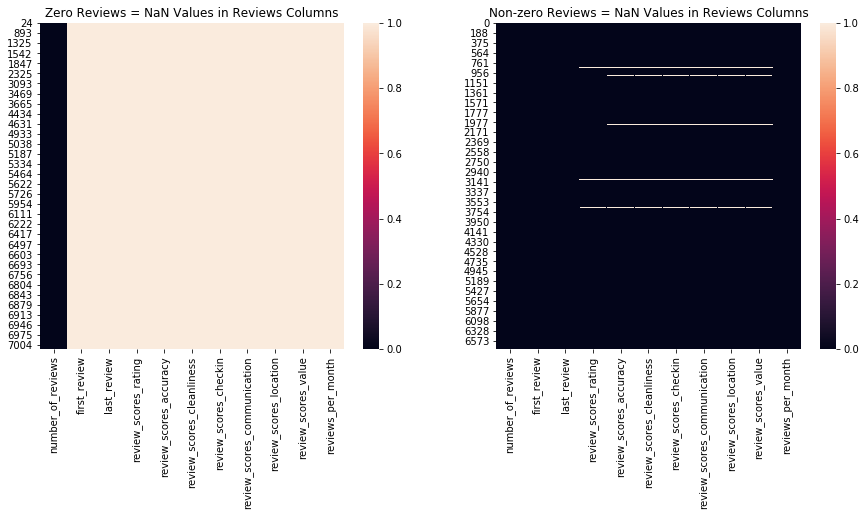

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax1, ax2 = ax
ax1.set_title('Zero Reviews = NaN Values in Reviews Columns')
sns.heatmap(listings_df[review_cols][listings_df['number_of_reviews'] == 0].isnull(), ax=ax1)
ax2.set_title('Non-zero Reviews = NaN Values in Reviews Columns')
sns.heatmap(listings_df[review_cols][listings_df['number_of_reviews'] > 0].isnull(), ax=ax2)
plt.show()

Except a few exceptions, above hypothesis seems reasonable.
- For 'reviews_per_month', 'first_review', 'last_review' columns, we fill NaN with zero because they have actually no review yet.
- For review score columns, such as 'review_score_rating', filling NaN with zero might be unfair to new players. So, we will add a binary flag whether review is available to see review impact. And then, move it to dropping_cols.

In [17]:
# for following three columns, NaN is filled with zero
cols_to_fill = ['reviews_per_month', 'first_review', 'last_review']
listings_df[cols_to_fill] = listings_df[cols_to_fill].fillna(0.0)

In [18]:
# for review score columns, one binary flag is added to show whether scores are available.
# 'reviews_score_rating' is referred for all seven score columns.
listings_df['has_review_scores'] = listings_df['review_scores_rating'].notnull().astype(int)

In [19]:
# move the review_score columns to droppin_cols
for col in cols_to_fill+['number_of_reviews']:
    review_cols.remove(col)

dropping_cols += review_cols

#### 3.1.6. Check location columns for redundancies and duplicates.

In [20]:
# understanding the location_cols distribution 
listings_df[location_cols].describe()

,host_location,host_neighbourhood,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,jurisdiction_names
count,7009,6419,7017,7017,7017,7017,7017,7016,6985,6999,7017,7017,7017,7017
unique,204,141,13,79,88,17,11,3,39,4,13,1,1,3
top,"Seattle, Washington, United States",Capitol Hill,"Seattle, WA, United States",Capitol Hill,Broadway,Other neighborhoods,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,"{WASHINGTON,"" Seattle"","" WA""}"
freq,5457,423,6999,558,400,1334,7000,7014,661,6996,6999,7017,7017,6875


Location columns with too many variety will make too manay variables by dummy encoding.
- We use 'neighbourhood_group_cleansed' for its reasonable number of variety, i.e. 17. We move it into categorical columns list.
- We compare 'host_neighbourhood' and 'neighbourhood' columns whether both are same, and output into a new column for result.
- All other location columns are moved to dropping list.

In [21]:
# compare 'host_neightbourhood' and 'neighbourhood' and output the result into 'host_in_same_neighbourhood' column
listings_df['host_in_same_neighbourhood'] = (listings_df['host_neighbourhood'] == listings_df['neighbourhood']).astype(int)

In [22]:
# moving 'neighbourhood_group_cleansed' to categorical columns
cat_cols += ['neighbourhood_group_cleansed']

# remove the 'neighbourhood_group_cleansed' from location_cols
location_cols.remove('neighbourhood_group_cleansed')

# adding location_cols to dropping_cols
dropping_cols += location_cols

#### 3.1.7. Convert % columns into numeric.

In [23]:
# removing % mark in the end and converting to float.
for col in percent_cols:
    listings_df[col] = listings_df[col].apply(
        lambda x: float(x[:-1]) if type(x) == str else x)

In [24]:
# count the number of null values
listings_df[percent_cols].isnull().sum()

host_response_rate      1757
host_acceptance_rate     965
dtype: int64

- For 'host_response_rate', we will create a binary flag to show responce rate availability and drop original column.
- For 'host_acceptance_rate', we will full NaN with mean value.

In [25]:
# create a binary column to show response rate availability.
listings_df['has_host_response_rate'] = listings_df['host_response_rate'].notnull().astype(int)

# then, original column is moved to dropping list.
dropping_cols += ['host_response_rate']

In [26]:
# for 'host_acceptance_rate' column, NaN is filled mean value.
listings_df['host_acceptance_rate'].fillna(listings_df['host_acceptance_rate'].mean(), inplace=True)

#### 3.1.8. Remove '$' and ',' from price columns and convert them into numeric.

In [27]:
# remove $ marks and ',' marks.
for col in price_cols:
    listings_df[col] = listings_df[col].str.replace("[$, ]", "").astype("float")

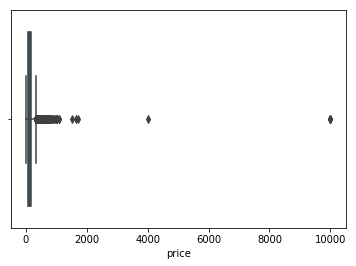

In [28]:
# plot the price column, to check for outliers
sns.boxplot(listings_df['price']);

- Some values in price seems like an outliers. We will drop such rows.

In [29]:
# drop the outlier rows
price_outliers = listings_df.query('price > 1000')
listings_df.drop(axis=0, index=price_outliers.index, inplace=True)

In [30]:
# check for null values in price columns
listings_df[price_cols].isnull().sum()

price                  0
weekly_price        6195
monthly_price       6361
security_deposit    1099
cleaning_fee         494
extra_people           0
dtype: int64

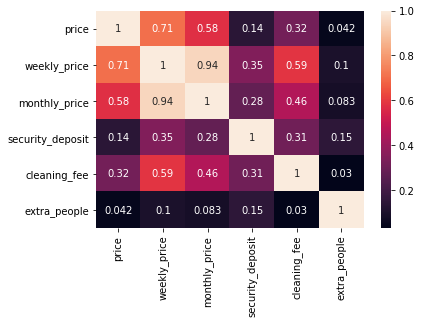

In [31]:
# understanding the price_cols correlation
sns.heatmap(listings_df[price_cols].corr(), annot=True);

- Naturally 'weekly_price' and 'monthly_price' have strong correlations with 'price'. We should drop it from predition features.
- For 'security_deposit' and 'cleaning_fee' columns, we will fill the NaN with mean considering them as maintenance charges.
- For dropping prices, we will add binary columns to show price availabilities.

In [32]:
# columns to be replaced with binary flags.
replacing_cols = ['weekly_price', 'monthly_price']

# adding 'has_' columns to show information availabilities.
for col in replacing_cols:
    listings_df['has_' + col] = listings_df[col].notnull().astype(int)

# adding strong correlated price to dropping_cols
dropping_cols += replacing_cols

In [33]:
# impute the 'security_deposit' and 'cleaning_fee' columns with mean
listings_df['security_deposit'] = listings_df['security_deposit'].fillna(listings_df['security_deposit'].mean())
listings_df['cleaning_fee'] = listings_df['cleaning_fee'].fillna(listings_df['cleaning_fee'].mean())

#### 3.1.9. Check distribution of numeric columns overall for NaN and outliers.

In [34]:
# understanding the distribution for num_cols
listings_df[num_cols].describe()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365
count,7005.000000,7005.000000,7005.000000,7005.000000,7005.000000,7004.000000,6999.000000,6937.000000,7005.000000,7005.000000,7005.000000,7005.000000,7005.000000,7005.000000,7005.000000
mean,127.867951,127.867951,47.625384,-122.333300,3.709636,1.316105,1.411059,1.907741,2.000143,12.919486,632.254390,12.254961,26.690650,42.096217,138.613704
std,412.792226,412.792226,0.046980,0.032518,2.329981,0.669946,1.015906,1.505897,1.646041,19.688554,536.669232,12.774393,25.079333,37.280374,133.489999
min,0.000000,0.000000,47.495870,-122.419250,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,47.603470,-122.354660,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,30.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,47.621090,-122.331880,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1125.000000,7.000000,23.000000,45.000000,93.000000
75%,9.000000,9.000000,47.661260,-122.310850,4.000000,1.500000,2.000000,2.000000,2.000000,30.000000,1125.000000,27.000000,54.000000,82.000000,263.000000
max,2036.000000,2036.000000,47.733950,-122.240950,25.000000,16.000000,8.000000,49.000000,16.000000,400.000000,10000.000000,30.000000,60.000000,90.000000,365.000000


- Small number of Nan in 'bathrooms', 'bedrooms', 'beds'. We will drop such rows.

In [35]:
# We drop these few NaN in row
listings_df.dropna(axis=0, subset=['bathrooms', 'bedrooms', 'beds'], inplace=True)

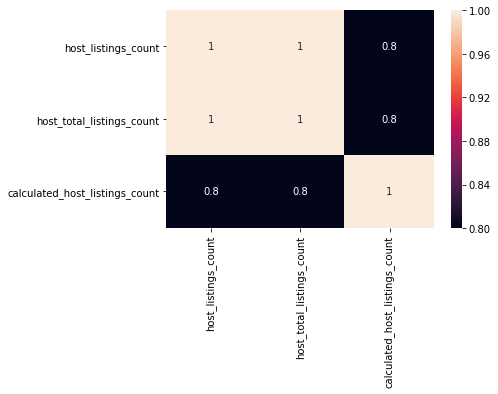

In [36]:
# understanding the correlation between host_listings_count
sns.heatmap(listings_df[['host_listings_count', 'host_total_listings_count', 
                         'calculated_host_listings_count']].corr(), annot=True);

- The first two are 1.0 correlation. We can drop one of them.

In [37]:
# moving 'host_listings_count' to dropping list
dropping_cols += ['host_listings_count']

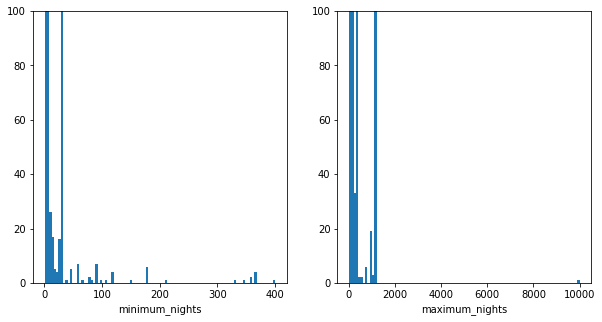

In [38]:
# checking distribution for suspected columns like maximum and minimum nights
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = ax
ax1.hist(listings_df['minimum_nights'], bins=100)
ax1.set_xlabel('minimum_nights')
ax1.set_ylim(top=100) 
ax2.hist(listings_df['maximum_nights'], bins=100)
ax2.set_xlabel('maximum_nights')
ax2.set_ylim(top=100)
plt.show()

- 'minimum_nights' : Near 1000 minimum nights is outlier. We will drop it.
- 'maximum_nights': Near 100000 maximum nights is outlier. But there might be other outliers. We magnitude x-axis as follows.

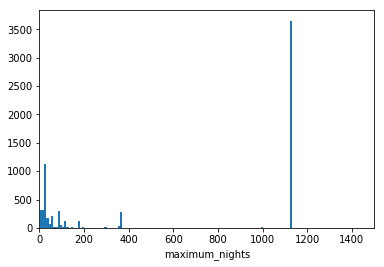

In [39]:
# display 'maximum_nights' distribution, adjusting x/y axis range.
plt.hist(listings_df['maximum_nights'], bins=1000)  # increased bins
plt.xlabel('maximum_nights')
plt.xlim(left=0, right=1500)  # set range limit for x-axis
plt.show()

'maximum_nights' still has unnatural peak near 1100. It might be due to some system restriction.<br>
So instead of keep it as numeric, we make it categorical as follows.
- nights <= a week
- a week < nights <= a month
- a month < nights <= 3 months
- 3 months < nights <= 6 months
- 6 months < nights <= 1 year
- 1 year < nights <= 3 years
- 3 years < nights

But first, we drop 'mininum_nights' outlier before we forget.

In [40]:
# dropping min nights outliers
min_night_outliers = listings_df.query('minimum_nights > 365')
listings_df.drop(axis=0, index=min_night_outliers.index, inplace=True)

In [41]:
# define a special function for maximum_nights conversion to categories
def cat_days_period(nights):
    '''
    args: nights (int) - number of days to be converted
    returns: categorized period (str) - 7 different range of periods
    '''
    if nights <= 7:
        return 'max_nighits_le7d'
    elif nights <= 31:
        return 'max_nights_mt7d_le1m'
    elif nights <= 3 * 31:
        return 'max_nights_mt1m_le3m'
    elif nights <= 6 * 31:
        return 'max_nights_mt3m_le6m'
    elif nights <= 365:
        return 'max_nights_mt6m_le1y'
    elif nights <= 3 * 365:
        return 'max_nigths_mt1y_le3y'
    else:
        return 'max_nights_mt3y'

# apply the function to 'maximum_nights' column
listings_df['maximum_nights'] = listings_df['maximum_nights'].apply(
    cat_days_period)

# Move 'maximum_nights' to categorical columns list.
cat_cols += ['maximum_nights']

#### 3.1.10. Decode special columns: 'host_verifications', 'amenities', and 'calendar_updated'.

In [42]:
# gist of encoded_cols
listings_df[encoded_cols].head()

,host_verifications,amenities,calendar_updated
0,"['email', 'phone', 'reviews', 'jumio', 'offlin...","{Internet,Wifi,Kitchen,""Free parking on premis...",today
1,"['email', 'phone', 'facebook', 'reviews', 'kba']","{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",6 months ago
2,"['email', 'phone', 'reviews', 'jumio', 'offlin...","{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",3 months ago
3,"['email', 'phone', 'reviews', 'kba']","{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",2 months ago
4,"['email', 'phone', 'reviews', 'kba']","{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",2 months ago


In [43]:
# checks value present in list, returns 0 or 1
def listed_value(row, column_name, value):
    '''
    Checks value present in rows list.
    Returns 0 or 1, helpfull in dummy creation.
    '''
    set_value = 0
    try:
        listed_values = row[column_name].strip('{}').strip('[]').replace("'", "").replace('"', '').split(',')
        if value in  listed_values:
            set_value = 1
    except:
        set_value = 0
    return set_value

# function for splitting lists in rows to columns
def split_rows_list_in_columns(df, column_name):
    '''
    Splits listed values in rows to columns.
    --------
    INPUT:
    df - pandas dataframe containing lists in rows.
    column_name - column name with such rows.
    --------
    OUTPUT:
    df - returns the dataframe with columns having 0 or 1 for each list values.
    t_list - return lists of column names newly created
    --------
    '''
    # dictionary of unique values in all rows across column
    list_values = {}
    
    # adds unique and counts the number of items in the row's list
    for unique_value in df[column_name].unique():
        unique_value_list = unique_value.strip('{}').strip('[]').replace('"', '').replace("'", "").split(',')
        for value in unique_value_list:
            if value in list_values:
                list_values[value] = list_values[value] + 1
            else:
                list_values[value] = 0
            
    # selecting popular values in list
    top_list = sorted(list_values.items(), key=lambda k: k[1], reverse=True)
    t_list = [] # later returns column names
    
    # split rows into columns
    for value in top_list[:25]:  # selects popular amenities upto 25 because total counts to 188
        df[column_name + '_' + value[0].strip()] = df.apply(lambda row: listed_value(row, column_name, value[0]), axis=1)   
        t_list += [column_name + '_' + value[0].strip()]
    
    return df, t_list

In [44]:
# create dummies values for host_verifications
listings_df, host_verify_list = split_rows_list_in_columns(listings_df, 'host_verifications')

# add the column to dropping_cols list
dropping_cols += ['host_verifications']

In [45]:
listings_df[host_verify_list].head()

,host_verifications_email,host_verifications_phone,host_verifications_government_id,host_verifications_reviews,host_verifications_offline_government_id,host_verifications_jumio,host_verifications_selfie,host_verifications_facebook,host_verifications_work_email,host_verifications_kba,host_verifications_identity_manual,host_verifications_google,host_verifications_phone,host_verifications_manual_offline,host_verifications_manual_online,host_verifications_zhima_selfie,host_verifications_sent_id,host_verifications_weibo,host_verifications_reviews
0,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [46]:
# create dummies values for amenities
listings_df, amenity_list = split_rows_list_in_columns(listings_df, 'amenities')

# move amenities to dropping_cols
dropping_cols += ['amenities']

In [47]:
listings_df[amenity_list].head()

,amenities_Wifi,amenities_Essentials,amenities_Heating,amenities_Smoke detector,amenities_Shampoo,amenities_Hangers,amenities_Carbon monoxide detector,amenities_Kitchen,amenities_Hair dryer,amenities_Laptop friendly workspace,...,amenities_Fire extinguisher,amenities_Refrigerator,amenities_Dishes and silverware,amenities_Microwave,amenities_Coffee maker,amenities_Free street parking,amenities_Cooking basics,amenities_Self check-in,amenities_Stove,amenities_Bed linens
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
1,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1


In [48]:
# list of unique values in calendar_updated
listings_df['calendar_updated'].unique()

array(['today', '6 months ago', '3 months ago', '2 months ago',
       '5 months ago', '4 months ago', 'a week ago', '3 days ago',
       '9 months ago', '7 months ago', '2 days ago', '38 months ago',
       'never', '3 weeks ago', '21 months ago', '5 days ago',
       '35 months ago', '2 weeks ago', '8 months ago', '7 weeks ago',
       '40 months ago', '4 weeks ago', '6 weeks ago', '5 weeks ago',
       '46 months ago', '32 months ago', '30 months ago', '14 months ago',
       '16 months ago', '27 months ago', '10 months ago', '11 months ago',
       '28 months ago', '24 months ago', '13 months ago', '48 months ago',
       '6 days ago', '29 months ago', '15 months ago', '17 months ago',
       'yesterday', '20 months ago', '4 days ago', '53 months ago',
       '34 months ago', '50 months ago', '51 months ago', '36 months ago',
       '12 months ago', '26 months ago', '47 months ago', '1 week ago',
       '43 months ago', '37 months ago', '25 months ago', '63 months ago',
       '19 

In [49]:
# decode 'calendar_updated' column with dedicated decoder function.
def decode_calendar_updated(value):
    '''
    args: value (str) - original string from 'calendar_updated' column
    returns: days (int) - decoded integer in days
    '''
    if 'today' in value:
        return 0
    elif 'yesterday' in value:
        return 1
    elif 'never' in value:
        return 365 * 7  # about 7 years
    elif 'day' in value:
        return int(re.findall(r"^(\d+) \D+", value)[0])
    elif 'a week' in value:
        return 7
    elif 'week' in value:
        return 7 * int(re.findall(r"^(\d+) \D+", value)[0])
    elif 'month' in value:
        return 31 * int(re.findall(r"^(\d+) \D+", value)[0])
    else:
        return value

# convert the calendar_updated column to numeric days
listings_df['calendar_updated'] = listings_df['calendar_updated'].apply(decode_calendar_updated)

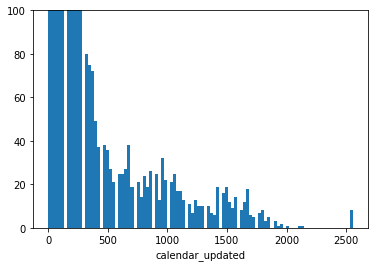

In [50]:
# checking distribution
plt.hist(listings_df['calendar_updated'], bins=100)
plt.xlabel('calendar_updated')
plt.ylim(top=100)
plt.show()

Those over 2500 outliers are original 'never'.<br>
We experienced similar unnatural outliers in 'maxmum_nights' column earler.<br>
And we use the same function to catetorize this column, too.

In [51]:
# apply the cat_days_period fuction to calendar_updated column.
listings_df['calendar_updated'] = listings_df['calendar_updated'].apply(cat_days_period)

# move 'calendar_updated' to categorical columns list
cat_cols += ['calendar_updated']

#### 3.1.11. Dummy encode all categorical columns.

In [52]:
listings_df = pd.get_dummies(listings_df, dummy_na=True, columns=cat_cols, drop_first=True)

#### 3.1.12. Drop all from dropping columns.

In [53]:
# dropping the columns from dataframe
listings_df.drop(dropping_cols, axis=1, inplace=True)

#### 3.1.13. Drop all id columns except 'id'. Make 'id' colum into index.

In [54]:
# make 'id' column into index.
listings_df.set_index('id', inplace=True)

In [55]:
# drop id_cols (except 'id' as index)
listings_df.drop(id_cols[1:], axis=1, inplace=True)
listings_df.head()

,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,...,maximum_nights_max_nights_mt7d_le1m,maximum_nights_max_nigths_mt1y_le3y,maximum_nights_nan,calendar_updated_max_nights_mt1m_le3m,calendar_updated_max_nights_mt3m_le6m,calendar_updated_max_nights_mt3y,calendar_updated_max_nights_mt6m_le1y,calendar_updated_max_nights_mt7d_le1m,calendar_updated_max_nigths_mt1y_le3y,calendar_updated_nan
id,,,,,,,,,,,,,,,,,,,,,
2318,434,1000,1000,404,200,0,40,70,0,4286,...,0,0,0,0,0,0,0,0,0,0
6606,496,999,1000,180,382,0,0,160,860,4043,...,0,0,0,0,1,0,0,0,0,0
9419,244,1000,1000,669,205,339,62,105,811,3938,...,0,0,0,1,0,0,0,0,0,0
9531,247,1000,1000,248,193,216,378,173,756,3934,...,0,1,0,1,0,0,0,0,0,0
9534,499,1000,1000,176,388,237,177,488,586,3934,...,0,0,0,1,0,0,0,0,0,0


### 3.2. Prepare the Calendar dataset.

>**TODO:**
- Convert 'date' column into pandas datetime format. Then, extract 'year' and 'month' into new columns.
- Convert 'price' column into numeric.
- Then, make a monthly price trend as well as seasonal factor index.

#### 3.2.1. Convert 'date' column into pandas datetime format. Then, extract 'year' and 'month' into new columns.

In [56]:
# convert to pandas datetime format.
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [57]:
# adding new columns for 'year' and 'month'.
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month

#### 3.2.2. Convert 'price' column into numeric.

In [58]:
# Remove dollar ($) and commas (,). Then convert to float.
calendar_df['price'] = calendar_df['price'].str.replace("[$, ]", "").astype("float")

#### 3.2.3.  Making a monthly price trend as well as seasonal factor index.

In [59]:
# calculate monthly mean price of all listings.
price_per_month = calendar_df.groupby(['month', 'year'])['price'].mean().to_frame()
price_per_month.reset_index(inplace=True)

In [60]:
# make a column for seasonal factor
price_per_month['season_factor'] = price_per_month['price'] / calendar_df['price'].mean()
price_per_month

,month,year,price,season_factor
0,1,2021,156.723630,0.979687
1,2,2021,158.408197,0.990217
2,3,2021,163.160987,1.019927
3,4,2021,168.068144,1.050602
4,5,2020,145.524786,0.909682
5,5,2021,168.537273,1.053534
6,6,2020,157.732773,0.985995
7,7,2020,171.072511,1.069382
8,8,2020,170.128825,1.063483
9,9,2020,161.557703,1.009905


As the data is available from June, 2020 to May, 2021. So, we shall reindex the columns as per need.<br>
Also, data for days in month of May, 2020 is much less as compared to May, 2021. So, we well remove the row.

In [61]:
# remove the May 2020 from dataframe
price_per_month = price_per_month.drop_duplicates(subset=['month'], keep='last')

In [62]:
# re-arrange the data as per the year
price_per_month = price_per_month.sort_values("year")

# reindex the data
price_per_month = price_per_month.reset_index().drop(columns=['index'])

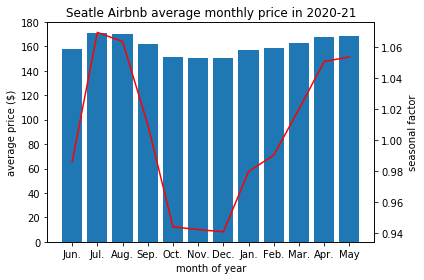

In [63]:
# plot the average price trend and seasonal factor for each month.
fig, ax1 = plt.subplots()
ax2 = plt.twinx()
ax1.bar(price_per_month.index, price_per_month.price)
ax2.plot(price_per_month.index, price_per_month.season_factor, c='red')
plt.xticks(ticks=np.arange(0, 12), labels=[
           'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 
           'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May'])
ax1.set_xlabel('month of year')
ax1.set_ylabel('average price ($)')
ax2.set_ylabel('seasonal factor')
plt.title('Seatle Airbnb average monthly price in 2020-21')
plt.tight_layout()
plt.show()

_**Observations:**_

- The prices were high in the month of July and August, 2020.
- Their has been noted a depletion in price value for the months Oct., Nov. and Dec. 2020.
- Also, the rise in value has been seen for the coming year.

### 3.3. Prepare the Reviews dataset.

>**TODO:**
- Convert 'date' column into pandas datetime format. Then, extract 'year' and 'month' into new columns.
- Make a monthly review count trend through all years.
- Also make yearly unique listing count trend.

#### 3.3.1. Convert 'date' column into pandas datetime format. Then, extract 'year' and 'month' into new columns.

In [64]:
# convert date column from string to pandas datetime format.
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

# extract year and month information into new columns.
reviews_df['year'] = reviews_df['date'].dt.year
reviews_df['month'] = reviews_df['date'].dt.month

#### 3.3.2. Make a monthly review count trend through all years.

In [65]:
reviews_df['date'].describe()

count                  387809
unique                   3303
top       2019-09-02 00:00:00
freq                      885
first     2008-09-15 00:00:00
last      2020-05-20 00:00:00
Name: date, dtype: object

Total reviews are collected from Sept.,2008 to May, 2020.

In [66]:
# group by year and month for reviewer_id count
reviews_per_month = reviews_df.groupby(['year', 'month'])['reviewer_id'].count()

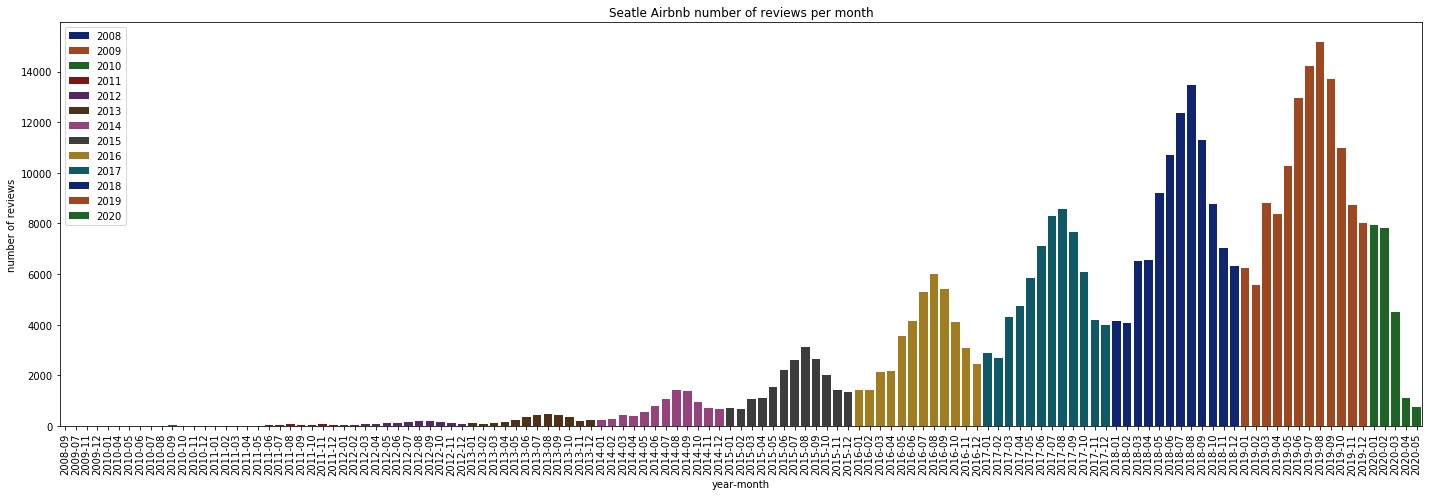

In [67]:
# plot the monthly review count trend through multiple years.
fig = plt.figure(figsize=(20, 7))
sns.barplot(reviews_per_month.index, reviews_per_month.values,
            hue=reviews_per_month.index.get_level_values(0), dodge=False, palette='dark')
plt.legend(loc='upper left')
plt.xticks(ticks=range(reviews_per_month.shape[0]),  rotation=90,
           labels=['{}-{:02}'.format(y, m) for (y, m) in reviews_per_month.index.values])
plt.xlabel('year-month')
plt.ylabel('number of reviews')
plt.title('Seatle Airbnb number of reviews per month')
plt.tight_layout()
plt.show()

_**Observations:**_

- Number of reviews are exponentially increasing from 2009 to 2019. But a drop is seen in year 2020.
- Peak of montly review count is in August. But as reviews are considered to be posted after check-out time, businest time could be ealier also.

#### 3.3.3. Also make yearly unique listing count trend.

In [68]:
# group by year for unique listings count
listings_per_year = reviews_df.groupby(['year'])['listing_id'].nunique()

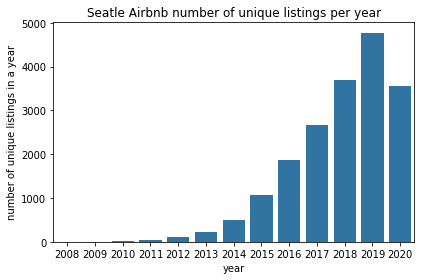

In [69]:
# plot the yearly unique listings count trend through multiple years.
fig = plt.figure()
sns.barplot(listings_per_year.index, listings_per_year.values, color=base_color)
plt.xlabel('year')
plt.ylabel('number of unique listings in a year')
plt.title('Seatle Airbnb number of unique listings per year')
plt.tight_layout()
plt.show()

_**Observations:**_

- Number of unique listings per year is exponentially increasing from 2008 to 2019.

## 4. Data Modelling
>**TODO:**
- Set 'price' column as a target of predictig model.
- Split data into training and testing.
- Instantiate model
- Fit training data to model
- Predict price from training/test data

### 4.1. Set 'price' column as a target of predictig model.

In [70]:
X = listings_df.drop(['price'], axis=1)
y = listings_df['price']

### 4.2. Split data into training and testing.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.3. Instantiate model

In [72]:
# instantiate random forest
rfr = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42, 
                            max_depth=20, min_samples_leaf=2, n_jobs=-1)

### 4.4. Fit training data to model

In [73]:
# fit data into random forest
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### 4.5. Predict price from training/test data

In [74]:
# predict and calculate r2_scores for the random forest
y_train_rfr_preds = rfr.predict(X_train)
y_test_rfr_preds = rfr.predict(X_test)

print('Random Forest R2 values of train: %.3f and test: %.3f' % (
        r2_score(y_train, y_train_rfr_preds),
        r2_score(y_test, y_test_rfr_preds)))

Random Forest R2 values of train: 0.938 and test: 0.674


The R<sup>2</sup> value of Random Forest Regressor for shows that the model might be overfitting. Let's check it.

## 5. Evaluate the result

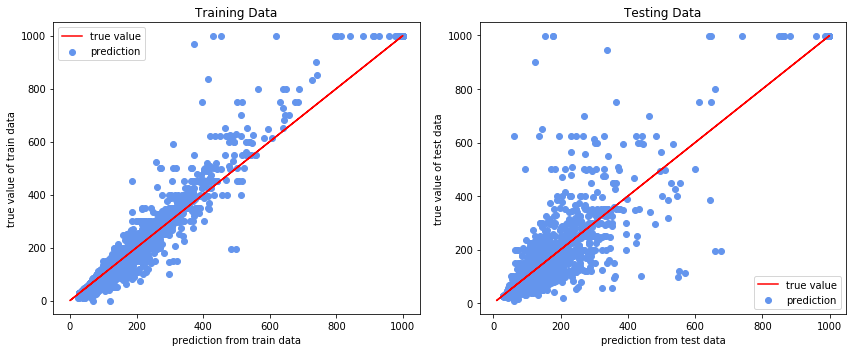

In [75]:
# plotting the prediction plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = ax

ax1.scatter(y_train_rfr_preds, y_train, c='cornflowerblue', label='prediction')
ax1.set_title('Training Data')
ax1.set_xlabel('prediction from train data')
ax1.set_ylabel('true value of train data') 
ax1.plot(y_train, y_train, c='red', label='true value')
ax1.legend()

ax2.scatter(y_test_rfr_preds, y_test, c='cornflowerblue', label='prediction')
ax2.set_title('Testing Data')
ax2.set_xlabel('prediction from test data')
ax2.set_ylabel('true value of test data') 
ax2.plot(y_test, y_test, c='red', label='true value')
ax2.legend()

plt.tight_layout()
plt.show()

- Looks like the model is predicting better in lower price range than higher price range.

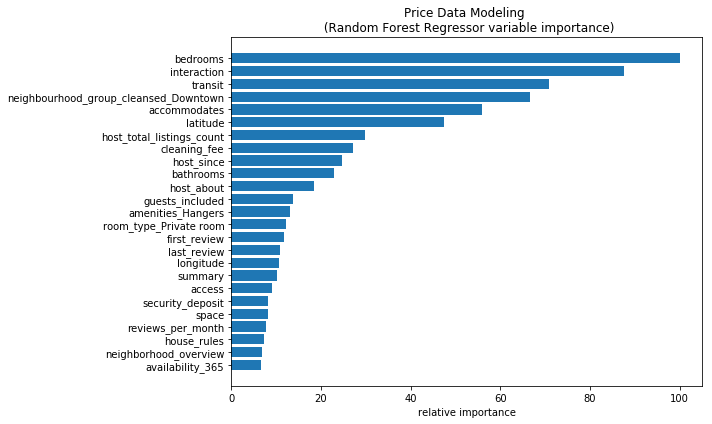

In [76]:
# Plot feature importance of random forest in sort order
feature_importance = rfr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())  # max-scaling
sorted_idx = np.argsort(feature_importance)

# Extracting top 25 features
top_feature_names = X.columns.values[sorted_idx][-25:]
top_feature_importance = feature_importance[sorted_idx][-25:]

# Plot
fig = plt.figure(figsize=(10,6))
pos = np.arange(len(top_feature_names))
plt.barh(pos, top_feature_importance, align='center')
plt.yticks(pos, top_feature_names)
plt.xlabel('relative importance')
plt.title('Price Data Modeling \n (Random Forest Regressor variable importance)')
plt.tight_layout()
plt.show()

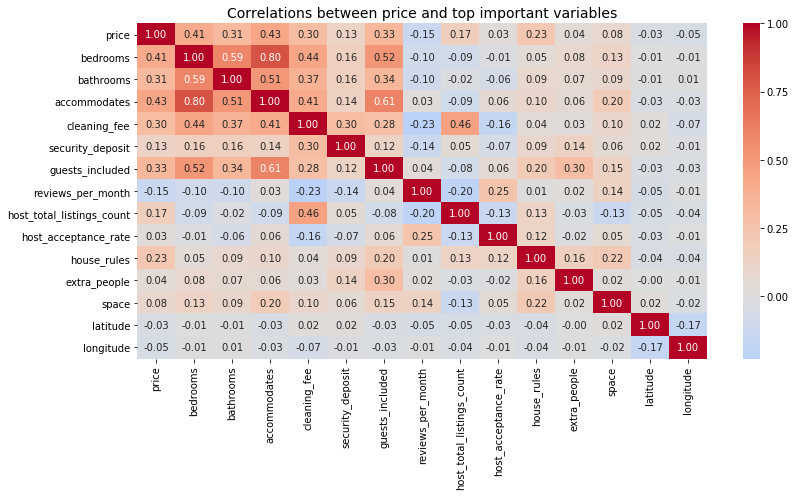

In [77]:
# In order to estimate positive / negative direction of each feature influence, 
# we plot correlations between price and top features.
top_features_rfr = ['price', 'bedrooms','bathrooms', 'accommodates', 'cleaning_fee', 'security_deposit', 
                    'guests_included', 'reviews_per_month','host_total_listings_count', 'host_acceptance_rate',
                    'house_rules', 'extra_people', 'space', 'latitude', 'longitude']
fig = plt.figure(figsize=[12,7])
sns.heatmap(listings_df[top_features_rfr].corr(), annot=True,fmt='.2f', 
            cmap='coolwarm', center=0.0, annot_kws={"size": 10})
plt.title('Correlations between price and top important variables',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

_**Observations:**_
- The modelling shows us the factors that have influence on price are: number of bedrooms, bathrooms, people it can accommodate along with the guests included and/or extra people;
- It is obvious that total price also involves the maintenance charges such cleaning fee and security deposit. 
- The host qualities are also important like number of host's listings and host acceptance rate.
- The pricing might depend on reviews and locations.

## Conclusions
Considering all the observations that we made throughtout the process, here are the answers to some prominent questions.

#### Q1. Does the price spikes in the busiest time of the year?
**Ans.1:**
- The busiest time of the year to visit Seattle is estimated to be middle of Summer, that is, the months of July and August.
- Also, it is been noticed that the prices does get high during the peak months.
<img src="average_monthly_price.png">
<img src="reveiws_per_month.png">

#### Q2. Is there any trend in Airbnb listings and total vistors?
**Ans.2:**
- Both number of visitor and number of listings are exponentially increaing from 2008 to 2019.
<img src="listings_per_year.png">

#### Q3. How well can we predict a price of Seattle Airbnb listings?
**Ans.3:**
- We can predict the price in R2 score 0.674 with Random Forest model.
<img src="prediction_plot.png">
- Regarding the Random Forest model, important features for price prediction is as follows:
    - number of bedrooms, bathrooms, people it can accommodate along with the guests included and/or extra people;
    - total price also involves the maintenance charges such cleaning fee and security deposit. 
    - The host qualities are also important like number of host's listings and host acceptance rate.
    - The pricing might depend on reviews and locations.
    <img src="feature_importance.png">
    <img src="feature_correlation.png">

### Further Reading
Read the Medium blog post on the same, [here.](https://medium.com/@cb.brijeshchandra/a-glimpse-of-listings-trend-and-price-spike-in-seattles-airbnb-ba744bf23ee9?sk=4c84a3c0ae80adcae39af32171afb6a4)